In [57]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.cross_validation import train_test_split
from sklearn import metrics
%matplotlib inline


In [6]:
# Load Data
df = pd.read_csv('ctrdata.csv', index_col=0)

In [7]:
df.head()

,Action,ID,ActionTime,Website,BannerSize,Brand,Color,StayTime
1,View,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1501207373254968,Facebook,728x90,JoeFresh,Pink,1.730627
2,View,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1501209660836689,Facebook,160x600,JoeFresh,Blue,0.615033
3,View,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1501209717498078,Facebook,160x600,Disney,Gold,1.232917
4,View,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1502831370458655,Other,300x250,Zara,Pink,1.004084
5,Click,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1502831506975457,Other,300x250,Carter's,White,0.204201


In [8]:
df.columns

Index(['Action', 'ID', 'ActionTime', 'Website', 'BannerSize', 'Brand', 'Color',
       'StayTime'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 8 columns):
Action        100000 non-null object
ID            100000 non-null object
ActionTime    100000 non-null int64
Website       100000 non-null object
BannerSize    100000 non-null object
Brand         100000 non-null object
Color         100000 non-null object
StayTime      99993 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 6.9+ MB


In [10]:
print(df.describe())
print('_'*40)
print(df.describe(include=['O']))
print('_'*40)
print(df.isnull().sum())

         ActionTime      StayTime
count  1.000000e+05  99993.000000
mean   1.506038e+15      1.000457
std    4.176429e+12      1.005150
min    1.500991e+15      0.000018
25%    1.502550e+15      0.286686
50%    1.504912e+15      0.692082
75%    1.508607e+15      1.386599
max    1.517356e+15     10.477972
________________________________________
        Action                            ID   Website BannerSize     Brand  \
count   100000                        100000    100000     100000    100000   
unique       2                          3093        16         15        10   
top       View  AMsySZYkZOPn04sH5gQG7xBcBGKz  Facebook    300x250  Carter's   
freq     90010                          2513     58059      43314     22438   

         Color  
count   100000  
unique       7  
top       Pink  
freq     32261  
________________________________________
Action        0
ID            0
ActionTime    0
Website       0
BannerSize    0
Brand         0
Color         0
StayTime      7
dty

In [11]:
# find null
df.isnull().sum()

Action        0
ID            0
ActionTime    0
Website       0
BannerSize    0
Brand         0
Color         0
StayTime      7
dtype: int64

In [12]:
# replace null with median
df.StayTime.fillna(df.StayTime.median(), inplace = True)
df.isnull().sum()

Action        0
ID            0
ActionTime    0
Website       0
BannerSize    0
Brand         0
Color         0
StayTime      0
dtype: int64

### Data Analysis and Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B801B38>,
      dtype=object)

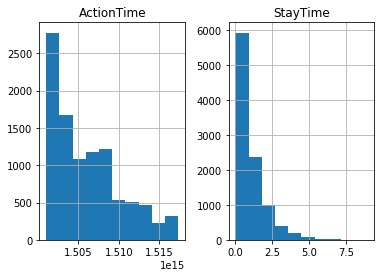

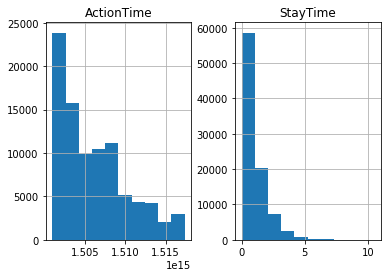

In [13]:
df[df.Action == 'Click'].hist()
df[df.Action == 'View'].hist()

In [14]:
mapping = {'View': 0, 'Click': 1}
df = df.replace({'Action': mapping})

In [15]:
df.describe()
df[df['Action']==0].shape

(90010, 8)

In [16]:
df.Website.value_counts()

Facebook         58059
instagram.com    15184
Other            14282
Craigslist.ca     3595
Yahoo             2363
Amazon            1601
TubeMogul         1185
Kijiji             886
Atedra             853
Sympatico          606
Expedia            474
Weather            438
Youtube            217
Twitter            123
Wayfair             93
AOL                 41
Name: Website, dtype: int64

In [17]:
# Baseline click through rate
df.Action.mean()

0.0999

To find the relationship between features and Action, I calculated the Click Through Rate(CTR) for each value of categorical features, and then sort the dataframe by CTR. We can see that BannerSize and Website seem like good predictors for Action.

In [18]:
df.groupby('Website').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()

,count,mean
Website,,
AOL,41,0.146341
Youtube,217,0.124424
Twitter,123,0.113821
Sympatico,606,0.107261
Craigslist.ca,3595,0.105702


In [19]:
df.groupby('Brand').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()

,count,mean
Brand,,
Disney,8392,0.106173
Zara,5524,0.102643
Burberry,8314,0.101997
JoeFresh,19101,0.101147
Carter's,22438,0.099162


In [20]:
df.groupby('BannerSize').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()

,count,mean
BannerSize,,
320x100,50,0.140000
768x1024,32,0.125000
1x1,400,0.112500
300x600,5247,0.106156
300x250,43314,0.100730


In [21]:
df.groupby('Color').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()

,count,mean
Color,,
Red,9267,0.103809
Yellow,18203,0.101412
White,5583,0.100484
Gold,16111,0.099497
other,4684,0.099488


### Feature Selection and Engineering

Convert the microseconds timestamp into a readable date format, assuming unix epoch time is 1970/01/01, UTC.

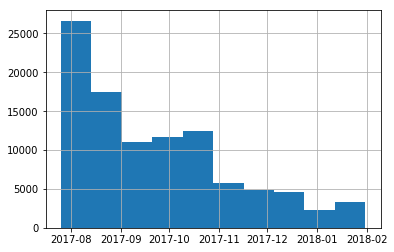

In [22]:
epoch = datetime(1970, 1, 1, tzinfo=timezone.utc)
mcs_format = df.ActionTime
date_format = []
for i in range(1, df.shape[0]+1):
    date_format.append(epoch + timedelta(microseconds=int(mcs_format[i])))
df['ActionTime_Date'] = pd.Series(date_format).values
df.head()
df.ActionTime_Date.hist()
#https://www.epochconverter.com/

Extract year, month, day, day of the week, hour, mininut into new columns. And map day of the week to 1 to 7.

In [23]:

df['Year'], df['Month'], df['Day'] = df['ActionTime_Date'].dt.year, df['ActionTime_Date'].dt.month, df['ActionTime_Date'].dt.day
df['Weekday'] = df['ActionTime_Date'].dt.weekday_name
mapping = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df = df.replace({'Weekday': mapping})

In [24]:
df['Hour'], df['Minute'] = df['ActionTime_Date'].dt.hour, df['ActionTime_Date'].dt.minute

In [25]:
print(df.head())
print('_'*80)
print(df.describe())
print('_'*80)
print(df.describe(include=['O']))
print('_'*80)
df.info()

   Action                            ID        ActionTime   Website  \
1       0  AMsySZZ_MC-gwE-94t_QLt3kIbXh  1501207373254968  Facebook   
2       0  AMsySZZ_MC-gwE-94t_QLt3kIbXh  1501209660836689  Facebook   
3       0  AMsySZZ_MC-gwE-94t_QLt3kIbXh  1501209717498078  Facebook   
4       0  AMsySZZ_MC-gwE-94t_QLt3kIbXh  1502831370458655     Other   
5       1  AMsySZZ_MC-gwE-94t_QLt3kIbXh  1502831506975457     Other   

  BannerSize     Brand  Color  StayTime            ActionTime_Date  Year  \
1     728x90  JoeFresh   Pink  1.730627 2017-07-28 02:02:53.254968  2017   
2    160x600  JoeFresh   Blue  0.615033 2017-07-28 02:41:00.836689  2017   
3    160x600    Disney   Gold  1.232917 2017-07-28 02:41:57.498078  2017   
4    300x250      Zara   Pink  1.004084 2017-08-15 21:09:30.458655  2017   
5    300x250  Carter's  White  0.204201 2017-08-15 21:11:46.975457  2017   

   Month  Day  Weekday  Hour  Minute  
1      7   28        5     2       2  
2      7   28        5     2      41  

Visually examin the relationship between time and Action. Weekday seems to have a stronger realtionship with Action than other 'time' variables.

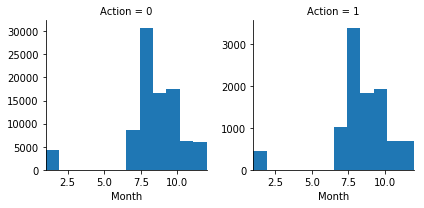

In [26]:
g = sns.FacetGrid(df, col='Action', sharey=False)
axes = g.axes
axes[0,0].set_xlim(1,12)
g.map(plt.hist, 'Month', bins=12)

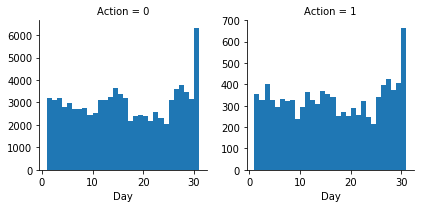

In [27]:
g = sns.FacetGrid(df, col='Action', sharey=False)
g.map(plt.hist, 'Day', bins=30)

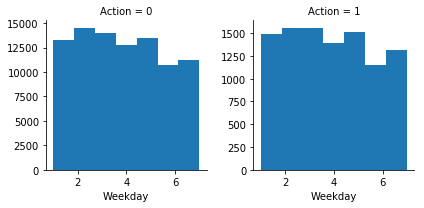

In [28]:
g = sns.FacetGrid(df, col='Action', sharey=False)
g.map(plt.hist, 'Weekday', bins=7)

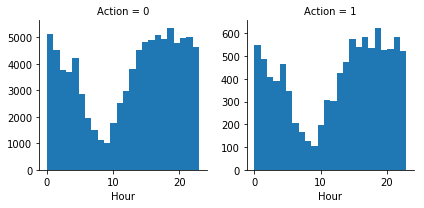

In [29]:
g = sns.FacetGrid(df, col='Action', sharey=False)
g.map(plt.hist, 'Hour', bins=24)

In [30]:
df.groupby('Weekday').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()
df.groupby('Month').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()
df.groupby('Year').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()
df.groupby('Day').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()
df.groupby('Hour').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()
df.groupby('Minute').Action.agg({'mean', 'count'}).sort_values('mean', ascending=False).head()

,count,mean
Minute,,
19,1612,0.113524
45,1626,0.111931
39,1609,0.111249
23,1732,0.110855
4,1727,0.110596


In [31]:
df.head()

,Action,ID,ActionTime,Website,BannerSize,Brand,Color,StayTime,ActionTime_Date,Year,Month,Day,Weekday,Hour,Minute
1,0,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1501207373254968,Facebook,728x90,JoeFresh,Pink,1.730627,2017-07-28 02:02:53.254968,2017,7,28,5,2,2
2,0,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1501209660836689,Facebook,160x600,JoeFresh,Blue,0.615033,2017-07-28 02:41:00.836689,2017,7,28,5,2,41
3,0,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1501209717498078,Facebook,160x600,Disney,Gold,1.232917,2017-07-28 02:41:57.498078,2017,7,28,5,2,41
4,0,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1502831370458655,Other,300x250,Zara,Pink,1.004084,2017-08-15 21:09:30.458655,2017,8,15,2,21,9
5,1,AMsySZZ_MC-gwE-94t_QLt3kIbXh,1502831506975457,Other,300x250,Carter's,White,0.204201,2017-08-15 21:11:46.975457,2017,8,15,2,21,11


Calculate the total time that a user viewed the advertisement.

In [32]:
sort_df = df.sort_values('ActionTime_Date', ascending=False)
sort_df.head()

,Action,ID,ActionTime,Website,BannerSize,Brand,Color,StayTime,ActionTime_Date,Year,Month,Day,Weekday,Hour,Minute
4127,0,AMsySZaNbHOuIdXp4Wzp7XGbw3qs,1517356357079943,Facebook,160x600,JoeFresh,Yellow,0.560764,2018-01-30 23:52:37.079943,2018,1,30,2,23,52
4126,0,AMsySZaNbHOuIdXp4Wzp7XGbw3qs,1517356164075182,Facebook,300x250,Carter's,Pink,0.821382,2018-01-30 23:49:24.075182,2018,1,30,2,23,49
4125,0,AMsySZaNbHOuIdXp4Wzp7XGbw3qs,1517356162085729,Facebook,300x250,JoeFresh,Pink,0.233819,2018-01-30 23:49:22.085729,2018,1,30,2,23,49
53833,0,AMsySZa0ABYW6uOqbq3SnPDDEYvc,1517355755883109,TubeMogul,Other,JoeFresh,Pink,0.765256,2018-01-30 23:42:35.883109,2018,1,30,2,23,42
53832,0,AMsySZa0ABYW6uOqbq3SnPDDEYvc,1517355716881124,TubeMogul,Other,Zara,Gold,0.873819,2018-01-30 23:41:56.881124,2018,1,30,2,23,41


In [33]:

# for i in range(0, df.shape[0]):
#     if sort_df['Action'].iloc[i] == 1:
#         for j in range(i+1, df.shape[0]):
#             if sort_df['Action'].iloc[j] != 1:
#             a=sort_df[['ID','Website','Brand']].iloc[i]==sort_df[['ID','Website','Brand'].iloc[j]]
            
            

# X = 

For categorical features, create dummy variables with only two values, 0 and 1.

In [34]:
cat_vars=['Website', 'BannerSize', 'Brand', 'Color', 'Weekday']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    df1=df.merge(cat_list, left_index=True, right_index=True)
    df=df1

In [35]:
exl_vars=['Website', 'BannerSize', 'Brand', 'Color', 'Weekday', 'ActionTime_Date', 'ID', 'ActionTime', 'StayTime', 'Year']
df_vars=df.columns.values.tolist()
to_keep=[i for i in df_vars if i not in exl_vars]
data_final=df[to_keep]
data_final.columns.values

array(['Action', 'Month', 'Day', 'Hour', 'Minute', 'Website_AOL',
       'Website_Amazon', 'Website_Atedra', 'Website_Craigslist.ca',
       'Website_Expedia', 'Website_Facebook', 'Website_Kijiji',
       'Website_Other', 'Website_Sympatico', 'Website_TubeMogul',
       'Website_Twitter', 'Website_Wayfair', 'Website_Weather',
       'Website_Yahoo', 'Website_Youtube', 'Website_instagram.com',
       'BannerSize_1200x627', 'BannerSize_1536x2048',
       'BannerSize_160x600', 'BannerSize_1x1', 'BannerSize_300x250',
       'BannerSize_300x50', 'BannerSize_300x600', 'BannerSize_320x100',
       'BannerSize_320x480', 'BannerSize_320x50', 'BannerSize_728x90',
       'BannerSize_750x125', 'BannerSize_768x1024', 'BannerSize_Other',
       'BannerSize_other', 'Brand_Banana Republic', 'Brand_Burberry',
       "Brand_Carter's", 'Brand_Disney', 'Brand_Gap', 'Brand_JoeFresh',
       'Brand_Old Navy', "Brand_The Children's Place", 'Brand_Zara',
       'Brand_gymboree', 'Color_Blue', 'Color_Gold', 'C

In [36]:
data_final.head()

,Action,Month,Day,Hour,Minute,Website_AOL,Website_Amazon,Website_Atedra,Website_Craigslist.ca,Website_Expedia,...,Color_White,Color_Yellow,Color_other,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7
1,0,7,28,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,7,28,2,41,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,7,28,2,41,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,8,15,21,9,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1,8,15,21,11,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [37]:
data_final_vars=data_final.columns.values.tolist()
y = data_final['Action']
X = data_final.iloc[:,1:61]

In [38]:
print(y.shape)
print(X.shape)


(100000,)
(100000, 59)


### Create Model

#### Logistic Regression

In [39]:
logreg = LogisticRegression()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [41]:
# null accuracy
max(y_test.mean(), 1 - y_test.mean())

0.8982

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 59)
(30000, 59)
(70000,)
(30000,)


In [43]:
y_test.value_counts()
y_train.value_counts()

0    63064
1     6936
Name: Action, dtype: int64

In [44]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
y_pred = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

0.8982
[[26946     0]
 [ 3054     0]]


In [46]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_prob.shape

(30000,)

In [47]:
y_pred_prob.max()

0.1391508193551032

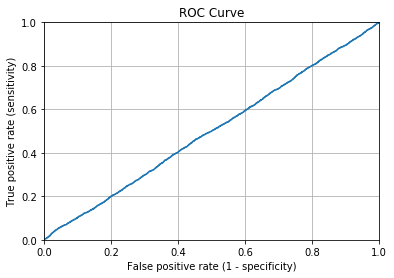

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.grid(True)

#### use Recursive Feature Elimination (RFE) to select feature

In [49]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False False False False False False False
 False False  True  True False False  True False False  True False False
 False  True False  True  True False False  True False False False False
 False False False False False False False False False  True  True  True
  True  True  True  True False  True  True  True False  True False]
[37 40 38 39  1 29 26 30  6 23 24 27 31 28  1  1 25 22  1 21 32  1 34  5
 35  1 20  1  1  8 33  1  9 36 19 10 16 14 18  7 15 13 12 17 11  1  1  1
  1  1  1  1  2  1  1  1  3  1  4]


In [50]:
X.columns.values

array(['Month', 'Day', 'Hour', 'Minute', 'Website_AOL', 'Website_Amazon',
       'Website_Atedra', 'Website_Craigslist.ca', 'Website_Expedia',
       'Website_Facebook', 'Website_Kijiji', 'Website_Other',
       'Website_Sympatico', 'Website_TubeMogul', 'Website_Twitter',
       'Website_Wayfair', 'Website_Weather', 'Website_Yahoo',
       'Website_Youtube', 'Website_instagram.com', 'BannerSize_1200x627',
       'BannerSize_1536x2048', 'BannerSize_160x600', 'BannerSize_1x1',
       'BannerSize_300x250', 'BannerSize_300x50', 'BannerSize_300x600',
       'BannerSize_320x100', 'BannerSize_320x480', 'BannerSize_320x50',
       'BannerSize_728x90', 'BannerSize_750x125', 'BannerSize_768x1024',
       'BannerSize_Other', 'BannerSize_other', 'Brand_Banana Republic',
       'Brand_Burberry', "Brand_Carter's", 'Brand_Disney', 'Brand_Gap',
       'Brand_JoeFresh', 'Brand_Old Navy', "Brand_The Children's Place",
       'Brand_Zara', 'Brand_gymboree', 'Color_Blue', 'Color_Gold',
       'Color_Pink'

In [51]:
cols = X.columns.values[rfe.support_]
cols

array(['Website_AOL', 'Website_Twitter', 'Website_Wayfair',
       'Website_Youtube', 'BannerSize_1536x2048', 'BannerSize_300x50',
       'BannerSize_320x100', 'BannerSize_320x480', 'BannerSize_750x125',
       'Color_Blue', 'Color_Gold', 'Color_Pink', 'Color_Red',
       'Color_White', 'Color_Yellow', 'Color_other', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_6'], dtype=object)

In [52]:
X=data_final[cols]
y=data_final['Action']

In [53]:
print(X.shape)
print(y.shape)

(100000, 20)
(100000,)


Try logistic regression again with 20 selected features

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [55]:
# null accuracy
max(y_test.mean(), 1 - y_test.mean())

0.8982

In [60]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
df=pd.DataFrame(y_pred)
df.to_csv("ctrpredictions.csv",index=False,header=None)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

0.8982
[[26946     0]
 [ 3054     0]]
